In [1]:
import sys 
sys.path.append('../')
from backtester import *
import sqlite3

In [2]:
ticker = 'EUR/USD'
freq = 'm15'
conn = sqlite3.connect(f'../PriceData/PriceData_{freq}.db')
data = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
for col in ['open', 'high', 'low', 'close']:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
display(data)
conn.close()

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-07-05 05:45:00,1.18554,1.18524,1.18569,1.18521,1.18567,1.18537,1.18582,1.18534,935,1.185605,1.185755,1.185275,1.185305
2021-07-05 06:00:00,1.18524,1.18557,1.18590,1.18512,1.18537,1.18571,1.18603,1.18524,2025,1.185305,1.185965,1.185180,1.185640
2021-07-05 06:15:00,1.18557,1.18559,1.18567,1.18526,1.18571,1.18570,1.18579,1.18537,1414,1.185640,1.185730,1.185315,1.185645
2021-07-05 06:30:00,1.18559,1.18649,1.18652,1.18557,1.18570,1.18662,1.18665,1.18569,3434,1.185645,1.186585,1.185630,1.186555
2021-07-05 06:45:00,1.18649,1.18627,1.18660,1.18602,1.18662,1.18638,1.18672,1.18615,2164,1.186555,1.186660,1.186085,1.186325
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-25 01:45:00,1.12084,1.12065,1.12084,1.12054,1.12096,1.12078,1.12096,1.12067,982,1.120900,1.120900,1.120605,1.120715
2021-11-25 02:00:00,1.12065,1.12089,1.12100,1.12060,1.12079,1.12101,1.12112,1.12071,835,1.120720,1.121060,1.120655,1.120950
2021-11-25 02:15:00,1.12090,1.12106,1.12112,1.12083,1.12101,1.12117,1.12124,1.12094,783,1.120955,1.121180,1.120885,1.121115


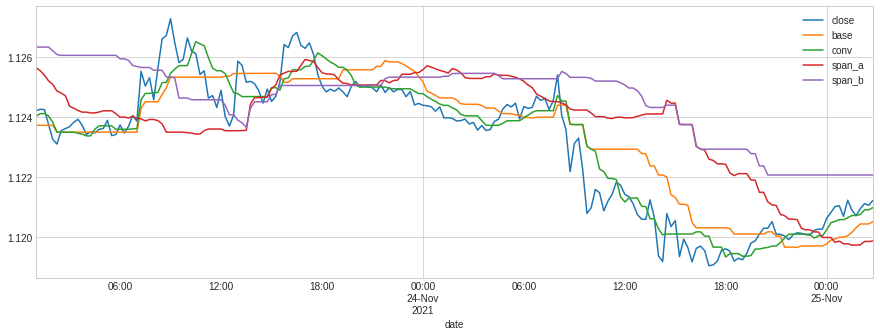

In [29]:
windows = (9, 26, 52)
ichimoku = ta.trend.IchimokuIndicator(high=data['high'], low=data['low'], visual=True,
                                      window1=windows[0], window2=windows[1], window3=windows[2])
data['span_a'] = ichimoku.ichimoku_a()
data['span_b'] = ichimoku.ichimoku_b()
data['base'] = ichimoku.ichimoku_base_line()
data['conv'] = ichimoku.ichimoku_conversion_line()
data.dropna(inplace=True)
data[['close', 'base', 'conv', 'span_a', 'span_b']].iloc[-200:].plot(figsize=(15,5));

In [30]:
data.shape

(9800, 18)

In [43]:
data['signal'] = np.where(np.all([data['close'] > data[['span_a', 'span_b']].max(axis=1), 
                                  data['conv'] > data['base']], axis=0), 1,
                         np.where(np.all([data['close'] < data[['span_a', 'span_b']].min(axis=1), 
                                          data['conv'] < data['base']], axis=0), -1, np.nan))
data['signal'] = data['signal'].ffill().fillna(0)
# data['signal'] = np.where(data['conv'] > data['base'], 1,
#                           np.where(data['conv'] < data['base'], -1, 0))

# data['signal'] = np.where(data['close'] > data[['span_a', 'span_b']].max(axis=1), 1,
#                          np.where(data['close'] < data[['span_a', 'span_b']].min(axis=1), -1, np.nan))
# data['signal'] = data['signal'].ffill().fillna(0)

In [44]:
data['signal'].value_counts()

 1.0    5140
-1.0    4660
Name: signal, dtype: int64

In [45]:
data['signal'].diff(1).apply(np.abs).value_counts()

0.0    9215
2.0     584
Name: signal, dtype: int64

  0%|          | 0/9799 [00:00<?, ?it/s]

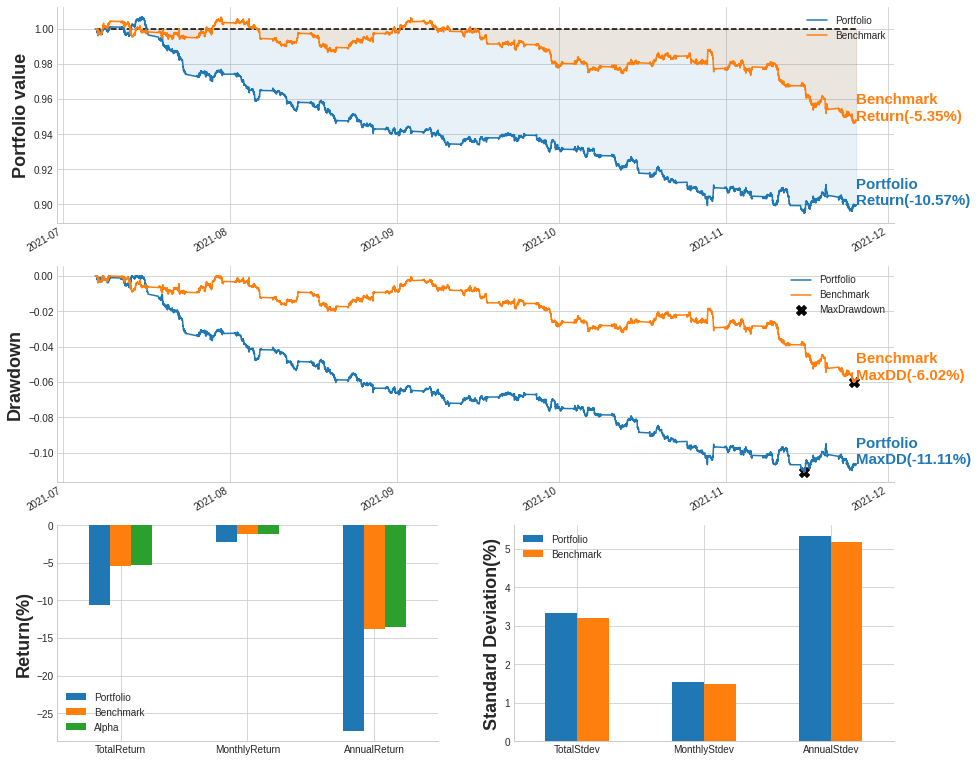

----------------------------------------------------------------------
Data length: |141 days 01:15:00|
Data range from |2021-07-07 01:30:00| to |2021-11-25 02:45:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │     -10.574 │      -5.349 │  -5.225 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │      -2.249 │      -1.138 │  -1.111 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │     -27.363 │     -13.842 │ -13.521 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │  

In [46]:
backtest = IterativeBacktester(data, data['signal'], freq)
backtest.backtest()
backtest.results()